## SFMS of the Illustris SFH catalog
The illustris catalog allows us to look at the SFMS evolution as a function of cosmic time

In [1]:
import numpy as np
import h5py 
import corner as DFM

import matplotlib.pyplot as plt
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline
# -- local -- 
import env 
import util as UT
from galprop import SFMS_bestfit

read in illustris catalog that's been preproprocessed in `catalog.py`

In [2]:
f = h5py.File(UT.dat_dir()+'illustris_sfh.hdf5', 'r')
# load into dict
galpop = {}
for k in f.keys(): 
    galpop[k] = f[k].value.flatten()

In [3]:
for i in range(5): 
    print galpop['sfr'+str(5*i)][:5]

[ 0.39341238  0.          1.55259516  2.03555549  0.06436089]
[ 1.10323553  0.          1.33578398  2.30654911  0.36153116]
[ 0.70156427  0.          0.7358465   1.74038257  0.35928362]
[ 0.704445    0.          0.92458961  1.32633038  0.28340277]
[ 0.56826116  0.03439504  0.72679295  2.29189405  0.32163241]


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



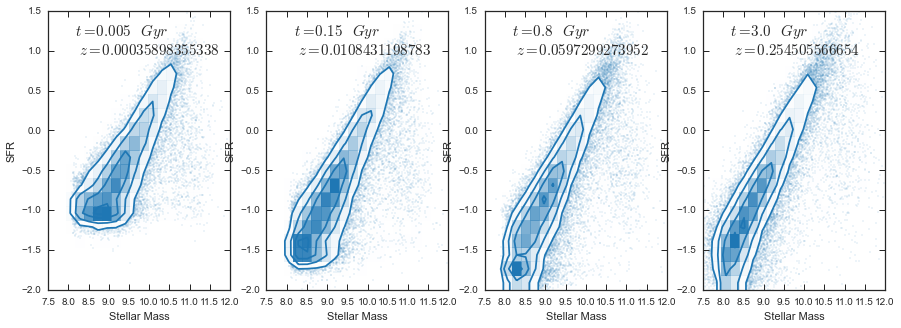

In [4]:
fig = plt.figure(figsize=(15,5)) 
for i in range(4): 
    sub = fig.add_subplot(1,4,i+1)
    DFM.hist2d(np.log10(galpop['m_star'+str(10*i)]), np.log10(galpop['sfr'+str(10*i)]), 
               range=[[7.5, 12.], [-2., 1.5]], color='#1F77B4')
    sub.text(0.15, 0.9, r"$t="+str(galpop['t'][10*i])+"\; Gyr$ \n $z="+str(galpop['z'][10*i])+"$", 
             ha='left', va='center', transform=sub.transAxes, fontsize=15)
    sub.set_xlabel('Stellar Mass')
    sub.set_xlim([7.5, 12.])
    sub.set_ylabel('SFR')
    sub.set_ylim([-2., 1.5])

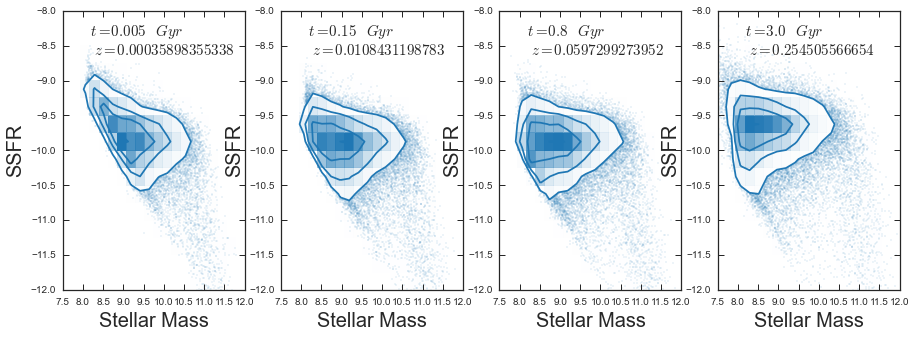

In [5]:
fig = plt.figure(figsize=(15,5)) 
for i in range(4): 
    sub = fig.add_subplot(1,4,i+1)
    DFM.hist2d(np.log10(galpop['m_star'+str(10*i)]), np.log10(galpop['sfr'+str(10*i)]) - np.log10(galpop['m_star'+str(10*i)]), 
               range=[[7.5, 12.], [-13., -8]], color='#1F77B4')
    sub.text(0.15, 0.9, r"$t="+str(galpop['t'][10*i])+"\; Gyr$ \n $z="+str(galpop['z'][10*i])+"$", 
             ha='left', va='center', transform=sub.transAxes, fontsize=15)
    sub.set_xlabel('Stellar Mass', fontsize=20)
    sub.set_xlim([7.5, 12.])
    sub.set_ylabel('SSFR', fontsize=20)
    sub.set_ylim([-12., -8.])

Lets fit the SFMS!

In [6]:
ssfrcut_const = lambda mm: -10.5*np.ones(mm.shape)

In [7]:
z_sample = np.arange(0., 0.8, 0.1)
i_z = [] 
for z in z_sample:
    indx = (np.abs(galpop['z'] - z)).argmin()
    i_z.append(indx)

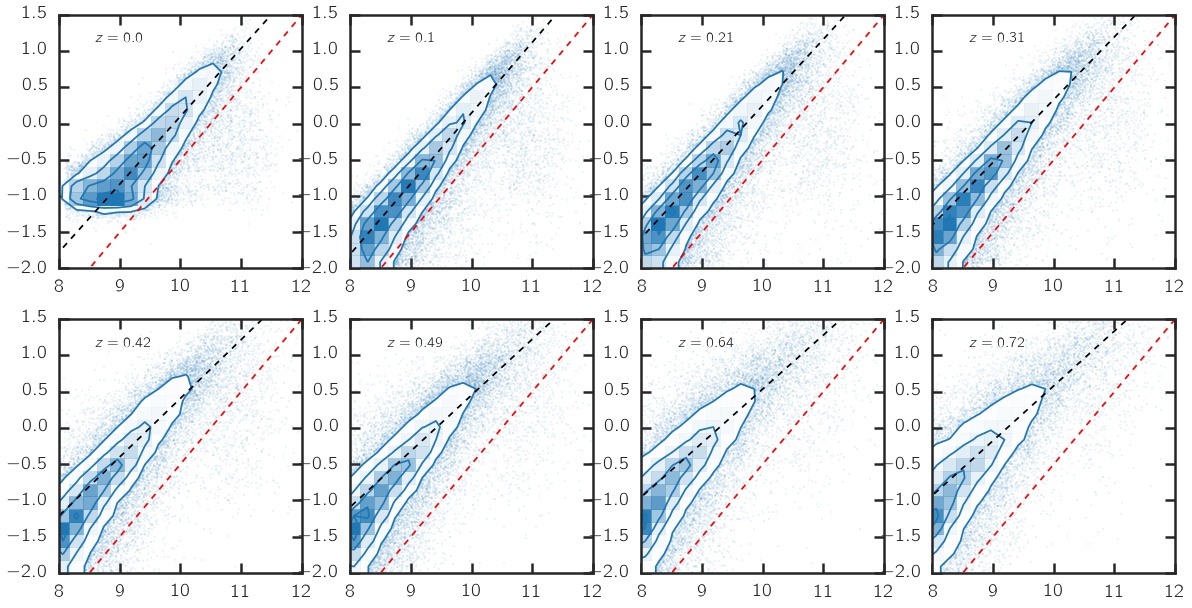

In [68]:
fig = plt.figure(figsize=(20,10))
for ii, i in enumerate(i_z): 
    sub = fig.add_subplot(2,4,ii+1)
    DFM.hist2d(np.log10(galpop['m_star'+str(i)]), np.log10(galpop['sfr'+str(i)]), 
               range=[[7.5, 12.], [-2., 1.5]], color='#1F77B4')
    f_sfms, sfms = SFMS_bestfit(np.log10(galpop['sfr'+str(i)]), np.log10(galpop['m_star'+str(i)]), 
                                f_SSFRcut=ssfrcut_const, fit_Mrange=[9., 11.], 
                                method='SSFRcut_gaussfit_linearfit', forTest=True)
    sub.text(0.15, 0.9, r"$z="+str(round(galpop['z'][i],2))+"$", 
             ha='left', va='center', transform=sub.transAxes, fontsize=15)
    m_arr = np.arange(7., 12.5, 0.5)
    sub.plot(m_arr, f_sfms(m_arr), c='k', ls='--')
    sub.plot(m_arr, ssfrcut_const(m_arr) + m_arr, c='r', ls='--')
    sub.set_xlim([8., 12.])
    sub.set_xticks(np.arange(8., 13., 1.))

0
0.00035898355338


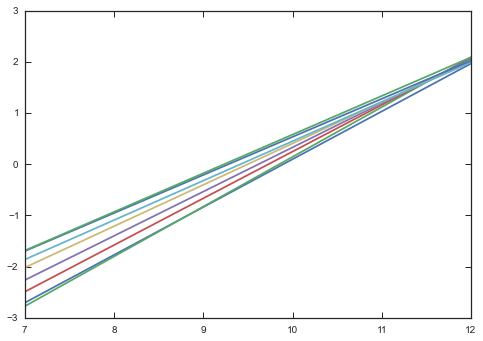

In [45]:
fig = plt.figure()
sub = fig.add_subplot(111)
for ii, i in enumerate(i_z): 
    f_sfms, sfms = SFMS_bestfit(np.log10(galpop['sfr'+str(i)]), np.log10(galpop['m_star'+str(i)]), 
                                f_SSFRcut=ssfrcut_const, fit_Mrange=[9., 11.], 
                                method='SSFRcut_gaussfit_linearfit', forTest=True)
    m_arr = np.arange(7., 12.5, 0.5)
    sub.plot(m_arr, f_sfms(m_arr))
    
    if ii == 0: 
        print i
        print galpop['z'][i]
        z0_sfms = f_sfms         
sf_cut = lambda mm: z0_sfms(mm) - 0.5

identify star-forming galaxies at $z \sim 0$

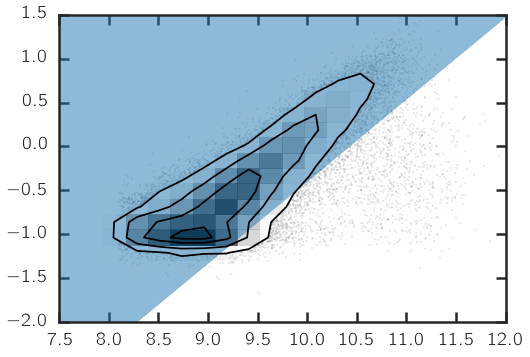

In [63]:
DFM.hist2d(np.log10(galpop['m_star0']), np.log10(galpop['sfr0']), 
               range=[[7.5, 12.], [-2., 1.5]], color='k')
m_arr = np.arange(7.5, 12.1, 0.1)
plt.fill_between(m_arr, sf_cut(m_arr), np.repeat(2.0, len(m_arr)), color='#1F77B4', alpha=0.5)

Calculate $\Delta log SFR = log SFR - log SFR_{SFMS}$

In [35]:
dlogsfr = np.zeros((len(galpop['m_star0']), len(galpop['z'])))
for i in range(40): 
    f_sfms, sfms = SFMS_bestfit(np.log10(galpop['sfr'+str(i)]), np.log10(galpop['m_star'+str(i)]), 
                                f_SSFRcut=ssfrcut_const, fit_Mrange=[9., 11.], 
                                method='SSFRcut_gaussfit_linearfit', forTest=True)
    dlogsfr[:,i] = np.log10(galpop['sfr'+str(i)]) - f_sfms(np.log10(galpop['m_star'+str(i)]))

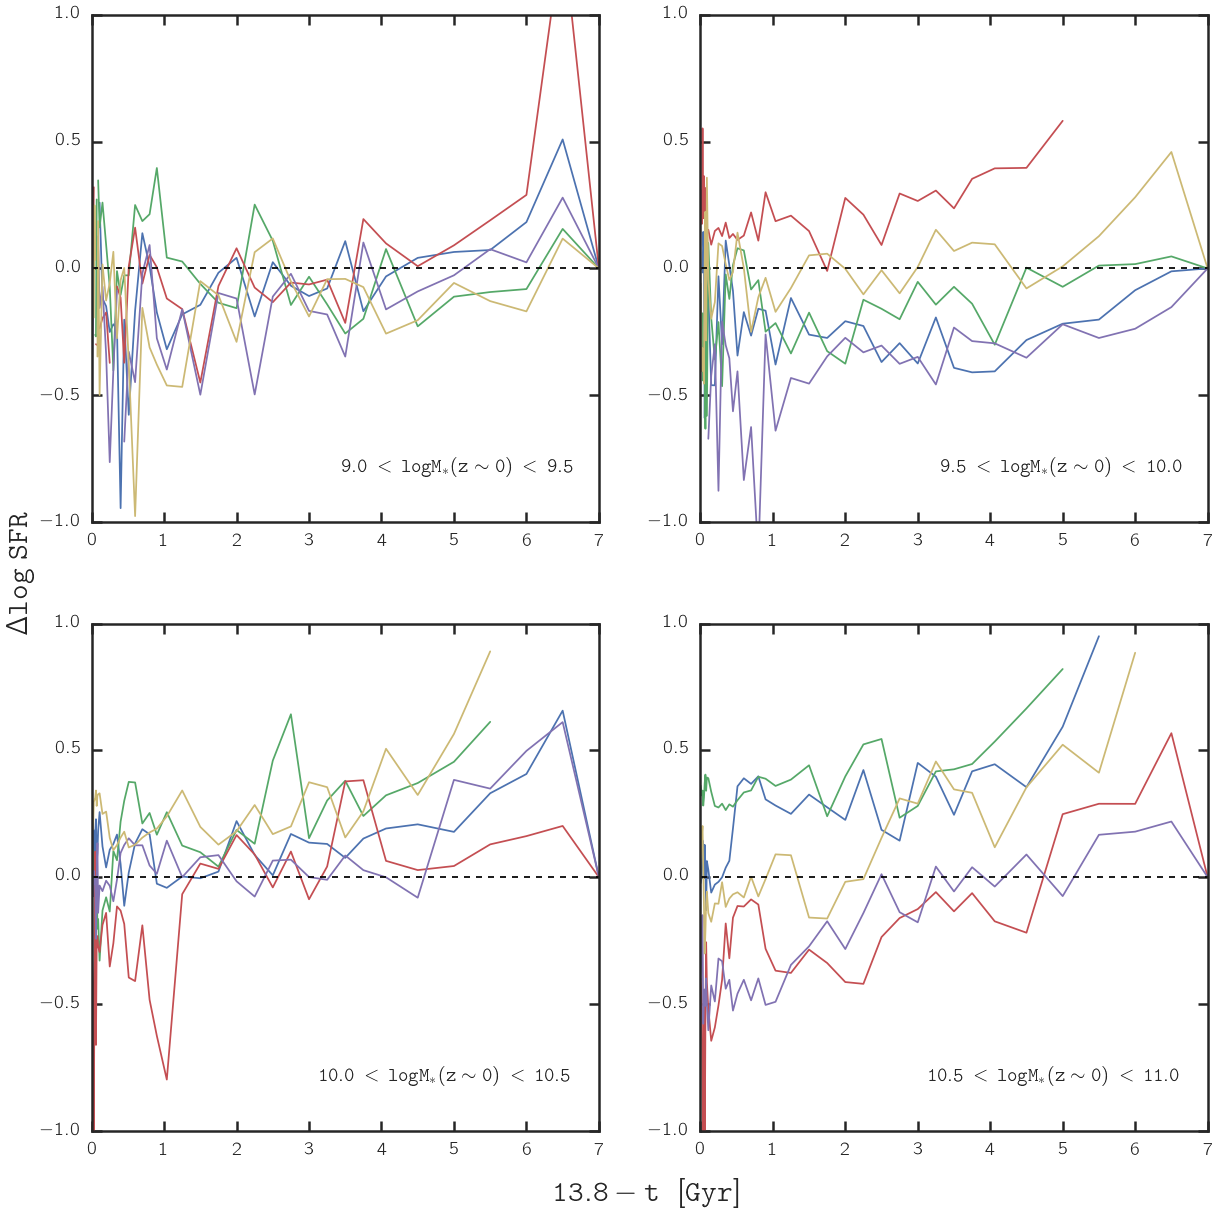

In [61]:
prettyplot()
fig = plt.figure(figsize=(20,20))
bkgd = fig.add_subplot(111, frameon=False)
mbins = np.arange(9.0, 11.5, 0.5)
for i_m in range(len(mbins)-1): 
    sub = fig.add_subplot(2,2, i_m+1)
    inmbin = np.where(
        (np.log10(galpop['m_star0']) > mbins[i_m]) & 
        (np.log10(galpop['m_star0']) < mbins[i_m+1]) & 
        (np.log10(galpop['sfr0']) > sf_cut(np.log10(galpop['m_star0']))))
    
    for ii in np.random.choice(range(len(inmbin[0])), size=5): 
        sub.plot(galpop['t'], dlogsfr[inmbin[0][ii],:])
    sub.plot(galpop['t'], np.repeat(0., len(galpop['t'])), c='k', ls='--')
    
    sub.text(0.95, 0.1, r"$\mathtt{"+str(mbins[i_m])+"\,< \, log M_*(z\sim 0)\, <\,"+str(mbins[i_m+1])+"}$", 
         ha='right', va='center', transform=sub.transAxes, fontsize=20)
    sub.set_ylim([-1., 1.])
    sub.set_xlim([0., 7.])
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
bkgd.set_ylabel(r'$\Delta \mathtt{log \; SFR}$', labelpad=20, fontsize=30)
bkgd.set_xlabel(r'$\mathtt{13.8 - t \;\; [Gyr]}$', labelpad=20, fontsize=30)